In [1]:
"""
广发证券-行为金融研究系列之六：A股羊群效应投资策略研究-201102
CSAD 方法
羊群效应中是过去1周的周涨幅与x比较
以周为单位，数据来自wind
"""
import pandas as pd
import numpy as np
import akshare as ak
import statsmodels.formula.api as smf
import datetime
import math
import matplotlib.pyplot as plt
class Herd_Effect(object):
    def __init__(self, params_grids):
        self.cash = params_grids['cash']
        self.capacity = params_grids['capacity']
        self.sector_code_list = ak.sw_index_spot()['指数代码']        
        self.A = params_grids['A']# 检测A周区间内是否存在羊群效应
        self.N = params_grids['N']# 选取有羊群效应的N个行业
        self.x = params_grids['x']# 有羊群效应的行业近期涨幅不应高于x
        self.Y = params_grids['Y']# 龙头股涨幅应大于Y
        self.Z = params_grids['Z']# 选取买入的股票周涨幅不应超过z
        self.M = params_grids['M']# 每个行业选择不超过M只股票

        self.sector_pctchange = pd.read_csv('D:/Python/Flies/Guanyun/A股数据/Herd_Data/Stock_beta/sector_weekly_pctchange.csv')
        self.all_stock_price_data = pd.read_csv('D:/Python/Flies/Guanyun/A股数据/Herd_Data/Stock-Daily-Close-XXXXXX.csv',dtype=str)
        self.stock_weekly_chg = pd.read_csv('D:/Python/Flies/Guanyun/A股数据/Herd_Data/Stock-Weekly-Change.csv')
        self.sector_pctchange.set_index(['date'],inplace=True)
        self.all_stock_price_data.set_index(['date'],inplace=True)
        self.stock_weekly_chg.set_index(['date'],inplace=True)
    
    def Herd_Testing(self, sector_code, date_now):
        """
        给定的行业指数sector_code，时间区间beginning至date_now，以CSAD检测是否存在羊群效应
        """
        OLS_data = pd.read_csv('D:/Python/Flies/Guanyun/A股数据/Herd_Data/CSAD method/' + sector_code + '.csv').set_index('Date')
        Rm_2_para = OLS_data.loc[date_now,['Rm^2 para']].values[0]
        Rm_2_pvalue = OLS_data.loc[date_now,['Rm^2 p_value']].values[0]
        
        RI = pd.read_excel('D:/Python/Flies/Guanyun/A股数据/Herd_Data/Rm Ri weekly change.xlsx',sheet_name = 'Ri').set_index('Date')
        A_weeks_sector_change = self.sector_pctchange.loc[date_now, sector_code]
        p_value = 0.6
        if Rm_2_para < 0 and Rm_2_pvalue <= p_value and A_weeks_sector_change < self.x : 
            return True,Rm_2_pvalue
        else:
            return False, Rm_2_pvalue
    
    
    def Leading_Testing(self,sector_code, date_now) : 
        """
        对sector下所有成分股筛选龙头股
        """
        stock_list = pd.read_csv('D:\\Python\\Flies\\Guanyun\\A股数据\\申万一级行业成份\\'+ sector_code +'.csv',dtype=str)
        for stock in stock_list['stock_code'] : 
            try:
                if self.stock_weekly_chg.loc[date_now,stock] > self.Y: 
                    return 1
            except : 
                print(stock,'has no data in date:',date_now)
        return 0  # 当前区间股票尚未发售等原因，无法提取数据
    
    
    def Choose_Stock(self, sector_code, date_now):
        """
        在已选行业，筛选|Ri − RI|收益偏离度小且周涨跌幅低于Z的个股，数量不超过M
        """
        stock_choose_list = pd.DataFrame(columns=['stock','CSAD_i'])
        stock_list = pd.read_csv('D:\\Python\\Flies\\Guanyun\\A股数据\\申万一级行业成份\\'+ sector_code +'.csv',dtype=str)['stock_code']
        stock_CSAD_i = pd.read_csv('D:/Python/Flies/Guanyun/A股数据/Herd_Data/CSAD method/'+ sector_code +'.csv',dtype=str).set_index('Date')
        for stock in stock_list : 
            stock_chg = self.stock_weekly_chg.loc[date_now, stock]
            if stock_chg < self.Z : 
                CSAD_i = stock_CSAD_i.loc[date_now, stock]
                stock_choose_list = stock_choose_list.append([{'stock':stock,'CSAD_i':CSAD_i}], ignore_index=True)
            
        if len(stock_choose_list) > self.M: 
            stock_choose_list = stock_choose_list.sort_values(by='CSAD_i',ascending=True)
            stock_choose_list = stock_choose_list.iloc[:self.M]
        return stock_choose_list['stock'].values


    def close_today(self, stock, date_now, method = 'next'):
        """
        默认获取最近一个交易日的close,stock为sh/sz+XXXXXX，method = next 时获取下一交易日的close
        """
        if method == 'lastest' : 
            day_1_stock = self.all_stock_price_data[(self.all_stock_price_data.index <= date_now)][stock].sort_index()
            day_1_stock = day_1_stock.dropna(how='any')
            return float(day_1_stock.iloc[-1])
        elif method == 'next' : 
            day_1_stock = self.all_stock_price_data[(self.all_stock_price_data.index >= date_now)][stock].sort_index()
            day_1_stock = day_1_stock.dropna(how='any')
            return float(day_1_stock.iloc[0])
    
    def trade( self, trade_list, cash, one_week_ago, date_now ):
        """
        通过index分别为收益，权重，买价，卖价的dataframe['return_chg','weight','close_when_buying','close_when_selling']
        记录持有股票的情况，每次换仓时结算换仓前持有的资产价值，并根据权重配比下一期的投资份额
        """
        # 获取换仓前的总资产
        return_sum = cash
        for stock in trade_list.columns.values : 
            trade_list.loc['close_when_selling'][stock] = self.close_today(stock, date_now)
            change = trade_list.loc['close_when_selling'][stock] / trade_list.loc['close_when_buying'][stock]
            return_sum +=  trade_list.loc['return_chg'][stock] * change
        # 清空trade_list中的stock
        trade_list = pd.DataFrame( index = ['return_chg','weight','close_when_buying','close_when_selling'] )
        return_sum_now = return_sum
        # 换仓
        
        herd_sector_list = pd.DataFrame(columns = ['sector','p_value'])

        for sector_code in self.sector_code_list : 
            herd = self.Herd_Testing(sector_code,  date_now)  # herd(tuple): herd[1]: True/False; [2]: parameter; [3]: p-value
            if herd[0] == True :  # 如果呈现出羊群效应，就检测龙头股数量
                if self.Leading_Testing(sector_code, date_now) == 1 :  # 且有龙头股数量也合适，买入
                    herd_sector_list = herd_sector_list.append([{'sector':sector_code,'p_value':herd[1]}], ignore_index=True)
        if len(herd_sector_list) > self.N: 
            herd_sector_list = herd_sector_list.sort_values(by='p_value',ascending=True)
            herd_sector_list = herd_sector_list.iloc[:self.N]
            
        for sector_code in herd_sector_list['sector'] : 
            choose_stock_list = self.Choose_Stock(sector_code, date_now)
            weight = 1 - ( herd_sector_list[herd_sector_list['sector'] == sector_code]['p_value'].values[0] )
            # 处理trade_list，新添入各龙头股
            for stock in choose_stock_list : 
                trade_list[stock] = None
                trade_list[stock]['close_when_buying'] = self.close_today(stock, date_now,'next')
                trade_list[stock]['weight'] = weight / len(choose_stock_list)
        weight_sum = trade_list.loc['weight'].sum() # 权重加总求权重的和，各个指数的权重为 权重/总权重和
        
        # 以weight权重分配现有资金return_sum
        for stock in trade_list.columns.values : 
            trade_list[stock]['return_chg'] = return_sum_now * ( trade_list[stock]['weight'] / weight_sum )
            return_sum -= trade_list[stock]['return_chg']
        return trade_list, return_sum    

    
    def display_performance(self, trade_list, performance_list, cash, one_week_ago, date_now) : 
        """
        通过index分别为收益，权重，买价，卖价的dataframe['return_chg','weight','close_when_buying','close_when_selling']
        在持有期内每天用当天的收盘价与买价比较，在performance_list中记录持有资产的每日价值变化
        """        
        # 获取交易日
        date_interval =self.all_stock_price_data[(self.all_stock_price_data.index <= date_now) &\
                                                 (self.all_stock_price_data.index >= one_week_ago)].sort_index().index.values
        
        for date in date_interval:
            if len(trade_list.columns.values) == 0 :  # 如果本月空仓
                performance_list.loc[date] = cash
            else: 
                capacity_num = cash
                for stock in trade_list.columns.values : 
                    trade_list.loc['close_when_selling'][stock] = self.close_today(stock, date,'next')
                    change = trade_list.loc['close_when_selling'][stock] / trade_list.loc['close_when_buying'][stock]
                    capacity_num +=  trade_list.loc['return_chg'][stock] * change
                performance_list.loc[date] = capacity_num
        print("_______________________________")
        print(one_week_ago, date_now)
        print(trade_list)
        print(date_now,performance_list.iloc[-1])
        print("_______________________________")

    
    def run(self):
        # 创建日期list : date_list
        date_list = self.sector_pctchange.index.to_list()
        # 创建trade_list
        trade_list = pd.DataFrame( index = ['return_chg','weight','close_when_buying','close_when_selling'] )
        
        # 创建performance_list
        performance_list = pd.DataFrame(columns=['capacity'])
        cash = self.cash

        # 对于date_list中的每一个时间段，判断是否达到信号进行交易，并检测保存下一时间段的performance
        for i in range(len(date_list)-2) : 
            trade_list, cash = self.trade(trade_list, cash, date_list[i], date_list[i+1] )
            if i != len(date_list)-3 : 
                self.display_performance( trade_list, performance_list,cash, date_list[i+1], date_list[i+2])
        return performance_list
        
        
if __name__ == '__main__':
    
    parameters_grid_dict = {
        'cash' : 1000000,
        'capacity' : 1000000,
        'beginning_date' : '2015-01-15',
        'ending_date' : '2020-01-01',
        'A' : 60,  # 检测A周区间内是否存在羊群效应
        'N' : 2,  # 选取有羊群效应的N个行业
        'x' : 13,  # 有羊群效应的行业近期涨幅不应高于x
        'Y' : 11,  # 龙头股涨幅应大于Y
        'Z' : 11, # 选取买入的股票周涨幅不应超过z
        'M' : 6 # 每个行业选择不超过M只股票
        }
    
    ml = Herd_Effect(params_grids=parameters_grid_dict)
    output = ml.run()


_______________________________
2015-01-16 2015-01-23
                           600237         000541         300256  \
return_chg          166666.666667  166666.666667  166666.666667   
weight                   0.090936       0.090936       0.090936   
close_when_buying            6.74         6.5075         4.9839   
close_when_selling           6.83         6.5673          5.163   

                           002547         002008         000823  
return_chg          166666.666667  166666.666667  166666.666667  
weight                   0.090936       0.090936       0.090936  
close_when_buying          5.4561        16.1075        10.7799  
close_when_selling         5.9947        16.5674        11.1572  
2015-01-23 capacity    1.036791e+06
Name: 2015-01-23, dtype: float64
_______________________________
_______________________________
2015-01-23 2015-01-30
                           300296         002409         600460  \
return_chg          172798.490738  172798.490738  172798.4

_______________________________
2015-03-13 2015-03-20
                          600715        300336        000038        002699  \
return_chg          203287.86385  203287.86385  203287.86385  203287.86385   
weight                  0.122286      0.122286      0.122286      0.122286   
close_when_buying        10.6401         11.32        13.682       10.9714   
close_when_selling       11.0007       14.0675       15.9745       13.6644   

                          300133        002638  
return_chg          203287.86385  203287.86385  
weight                  0.122286      0.122286  
close_when_buying        14.3705        6.1309  
close_when_selling       14.6124        6.8147  
2015-03-20 capacity    1.386013e+06
Name: 2015-03-20, dtype: float64
_______________________________
_______________________________
2015-03-20 2015-03-27
                           002247         300392         002238  \
return_chg          231002.146778  231002.146778  231002.146778   
weight               

_______________________________
2015-04-30 2015-05-08
                           300133         600455         300338  \
return_chg          137745.557293  137745.557293  137745.557293   
weight                   0.104794       0.104794       0.104794   
close_when_buying         15.3055          40.54        21.6354   
close_when_selling        15.8786          42.99        20.9671   

                           002027         601098         300031  \
return_chg          137745.557293  137745.557293  137745.557293   
weight                   0.104794       0.104794       0.104794   
close_when_buying          3.7668        20.0928        13.4086   
close_when_selling         3.7668        19.2036        13.1753   

                           000021         002189         002463  \
return_chg          134839.297847  134839.297847  134839.297847   
weight                   0.102583       0.102583       0.102583   
close_when_buying         13.0979        32.8451         7.4335   
close_

_______________________________
2015-06-26 2015-07-03
                           000557         002245         000828  \
return_chg          173493.785278  173493.785278  173493.785278   
weight                   0.102109       0.102109       0.102109   
close_when_buying            9.89         9.0646        13.6198   
close_when_selling           7.66         7.0709         9.5734   

                           600125         600190         002120  \
return_chg          173493.785278  173493.785278  173493.785278   
weight                   0.102109       0.102109       0.102109   
close_when_buying         15.1681         7.7874         9.3492   
close_when_selling        10.5334         5.9516         6.4723   

                           601618         002713         002717  \
return_chg          185320.612989  185320.612989  185320.612989   
weight                    0.10907        0.10907        0.10907   
close_when_buying           6.506        19.3362          6.227   
close_

_______________________________
2015-09-02 2015-09-11
                           002051         000779         600496  \
return_chg          111917.137762  111917.137762  111917.137762   
weight                   0.119524       0.119524       0.119524   
close_when_buying         12.2858         12.378         5.2266   
close_when_selling        12.6589         13.288         5.4731   

                           600284         300384         601669  \
return_chg          111917.137762  111917.137762  111917.137762   
weight                   0.119524       0.119524       0.119524   
close_when_buying          7.2927        18.8322         7.8187   
close_when_selling         8.7335        23.5837         7.4366   

                           601988         000001         002142  \
return_chg          124674.394923  124674.394923  124674.394923   
weight                   0.133148       0.133148       0.133148   
close_when_buying          3.1152         9.0971         8.4982   
close_

_______________________________
2015-11-13 2015-11-20
                           600039         002663         002051  \
return_chg          280195.363035  280195.363035  280195.363035   
weight                   0.073994       0.073994       0.073994   
close_when_buying           4.868         8.4401        15.5549   
close_when_selling         4.8866         8.8179        15.1692   

                           600820         000498         600970  
return_chg          280195.363035  280195.363035  280195.363035  
weight                   0.073994       0.073994       0.073994  
close_when_buying         10.8896         6.7603         7.2376  
close_when_selling        10.5912         7.0949         7.4297  
2015-11-20 capacity    1.701464e+06
Name: 2015-11-20, dtype: float64
_______________________________
_______________________________
2015-11-20 2015-11-27
                           000001         601166         600015  \
return_chg          283577.406491  283577.406491  283577.4

_______________________________
2016-06-03 2016-06-08
Empty DataFrame
Columns: []
Index: [return_chg, weight, close_when_buying, close_when_selling]
2016-06-08 capacity    1.692248e+06
Name: 2016-06-08, dtype: float64
_______________________________
_______________________________
2016-06-08 2016-06-17
                           600279         601880         603117  \
return_chg          138650.049627  138650.049627  138650.049627   
weight                   0.074695       0.074695       0.074695   
close_when_buying          6.6632         2.3891        12.8771   
close_when_selling          6.338         2.3683        12.4131   

                           002010         000099         600368  \
return_chg          138650.049627  138650.049627  138650.049627   
weight                   0.074695       0.074695       0.074695   
close_when_buying         18.1354        13.2708         3.3925   
close_when_selling        17.3145        12.6449         3.3585   

                        

_______________________________
2016-08-19 2016-08-26
Empty DataFrame
Columns: []
Index: [return_chg, weight, close_when_buying, close_when_selling]
2016-08-26 capacity    1.687796e+06
Name: 2016-08-26, dtype: float64
_______________________________
_______________________________
2016-08-26 2016-09-02
Empty DataFrame
Columns: []
Index: [return_chg, weight, close_when_buying, close_when_selling]
2016-09-02 capacity    1.687796e+06
Name: 2016-09-02, dtype: float64
_______________________________
_______________________________
2016-09-02 2016-09-09
                           002594         002328         002684  \
return_chg          152814.138531  152814.138531  152814.138531   
weight                   0.117853       0.117853       0.117853   
close_when_buying         56.7864          5.755        18.8371   
close_when_selling         57.915         6.0537        19.1832   

                           600418         603009         600081  \
return_chg          152814.138531  152814.1

_______________________________
2016-10-28 2016-11-04
Empty DataFrame
Columns: []
Index: [return_chg, weight, close_when_buying, close_when_selling]
2016-11-04 capacity    1.837377e+06
Name: 2016-11-04, dtype: float64
_______________________________
_______________________________
2016-11-04 2016-11-11
                           600368         600221         601006  \
return_chg          306229.465451  306229.465451  306229.465451   
weight                   0.098348       0.098348       0.098348   
close_when_buying          3.9512          3.151         5.5492   
close_when_selling         4.0329         3.1999          5.711   

                           600704         603885         601518  
return_chg          306229.465451  306229.465451  306229.465451  
weight                   0.098348       0.098348       0.098348  
close_when_buying          5.6448         17.412         4.0067  
close_when_selling         5.6719        17.2682         4.1796  
2016-11-11 capacity    1.86954

_______________________________
2017-02-17 2017-02-24
                           601018         001872         000099  \
return_chg          313004.172705  313004.172705  313004.172705   
weight                   0.095914       0.095914       0.095914   
close_when_buying          4.9836        17.1131        12.0973   
close_when_selling         5.0116        17.2927        12.5667   

                           601919         600662         000582  
return_chg          313004.172705  313004.172705  313004.172705  
weight                   0.095914       0.095914       0.095914  
close_when_buying            6.05         10.461        12.3466  
close_when_selling           6.23         10.509        12.0533  
2017-02-24 capacity    1.898527e+06
Name: 2017-02-24, dtype: float64
_______________________________
_______________________________
2017-02-24 2017-03-03
Empty DataFrame
Columns: []
Index: [return_chg, weight, close_when_buying, close_when_selling]
2017-03-03 capacity    1.89852

_______________________________
2017-05-05 2017-05-12
                           000708         002318         600022  \
return_chg          150435.777216  150435.777216  150435.777216   
weight                   0.166037       0.166037       0.166037   
close_when_buying          5.8534          7.366         2.0246   
close_when_selling         5.4658         7.0174         1.9476   

                           000761         600231         002110  \
return_chg          150435.777216  150435.777216  150435.777216   
weight                   0.166037       0.166037       0.166037   
close_when_buying          5.0468         2.5891         6.7762   
close_when_selling         4.7246         2.4343         6.5903   

                           600395         603979         000833  \
return_chg          132925.416134  132925.416134  132925.416134   
weight                    0.14671        0.14671        0.14671   
close_when_buying          5.5768        12.8634         7.7268   
close_

_______________________________
2017-06-16 2017-06-23
                           000611         002291         002269  \
return_chg          142915.956442  142915.956442  142915.956442   
weight                   0.146039       0.146039       0.146039   
close_when_buying           10.05          15.12           3.84   
close_when_selling          10.05          15.12           3.73   

                           002569         002098         002486        000012  \
return_chg          142915.956442  142915.956442  142915.956442  135359.64381   
weight                   0.146039       0.146039       0.146039      0.138318   
close_when_buying           52.88        13.9928           8.64        6.0793   
close_when_selling          52.88        13.9928           8.64        6.0003   

                          000789        300234        300198        002742  \
return_chg          135359.64381  135359.64381  135359.64381  135359.64381   
weight                  0.138318      0.138318  

_______________________________
2017-07-28 2017-08-04
                           600350         600012         600368  \
return_chg          163029.044708  163029.044708  163029.044708   
weight                   0.133029       0.133029       0.133029   
close_when_buying          5.5096         11.326         4.5052   
close_when_selling         5.4751        11.9473         4.4431   

                           600279         601000         603066  \
return_chg          163029.044708  163029.044708  163029.044708   
weight                   0.133029       0.133029       0.133029   
close_when_buying          6.2363         3.4426        12.6794   
close_when_selling         6.5449         3.5874        12.6794   

                           002478         600126         000717  \
return_chg          153411.365695  153411.365695  153411.365695   
weight                   0.125182       0.125182       0.125182   
close_when_buying          5.4933          5.418         5.2184   
close_

_______________________________
2017-09-08 2017-09-15
                           000507         600717         000900  \
return_chg          199347.934855  199347.934855  199347.934855   
weight                   0.129806       0.129806       0.129806   
close_when_buying         10.8663         8.1166         5.6997   
close_when_selling        10.4744         7.9179         5.5814   

                           600221         600179         300013  \
return_chg          199347.934855  199347.934855  199347.934855   
weight                   0.129806       0.129806       0.129806   
close_when_buying          3.2996         12.036        10.4045   
close_when_selling         3.2896        12.3494        10.0211   

                           601226         002811         002593  \
return_chg          145373.890118  145373.890118  145373.890118   
weight                   0.094661       0.094661       0.094661   
close_when_buying          6.2944        15.9353         5.0792   
close_

_______________________________
2017-10-27 2017-11-03
                          600846        300668        002298        603778  \
return_chg          191068.41133  191068.41133  191068.41133  191068.41133   
weight                  0.099182      0.099182      0.099182      0.099182   
close_when_buying        11.0736       33.8881       10.5195       10.1266   
close_when_selling        9.5712       37.0391        9.8038         9.113   

                          300237        603637        300144        600754  \
return_chg          191068.41133  191068.41133  161912.51427  161912.51427   
weight                  0.099182      0.099182      0.084047      0.084047   
close_when_buying         9.0722       12.7385       10.6075       28.1512   
close_when_selling        8.2374       12.1892       10.6674       28.3769   

                          603099        600593        600706        000888  
return_chg          161912.51427  161912.51427  161912.51427  161912.51427  
weight    

_______________________________
2017-12-08 2017-12-15
                           600707         300322         002106  \
return_chg          171758.256292  171758.256292  171758.256292   
weight                   0.091495       0.091495       0.091495   
close_when_buying            7.17        13.1207         9.6185   
close_when_selling           7.07        12.7543         9.8849   

                           002222         002369         300433  \
return_chg          171758.256292  171758.256292  171758.256292   
weight                   0.091495       0.091495       0.091495   
close_when_buying         19.5388         9.8128        22.6672   
close_when_selling         20.472         9.5148        20.0234   

                           600197         000568         002557  \
return_chg          134029.238451  134029.238451  134029.238451   
weight                   0.071397       0.071397       0.071397   
close_when_buying         22.0133        57.6557        15.1266   
close_

_______________________________
2018-01-19 2018-01-26
                           300217         000651         300247  \
return_chg          159940.746942  159940.746942  159940.746942   
weight                   0.126623       0.126623       0.126623   
close_when_buying          2.9057        47.6409         5.3991   
close_when_selling         2.9648        53.1503         5.4688   

                           002290         002420         600619  \
return_chg          159940.746942  159940.746942  159940.746942   
weight                   0.126623       0.126623       0.126623   
close_when_buying         12.3849            5.1        10.3565   
close_when_selling        12.5827           5.12        10.6842   

                           000690         603903         600163  \
return_chg          139074.180933  139074.180933  139074.180933   
weight                   0.110103       0.110103       0.110103   
close_when_buying          8.0945        19.2682           4.35   
close_

_______________________________
2018-03-09 2018-03-16
                           600575         601880         601000  \
return_chg          144601.037436  144601.037436  144601.037436   
weight                    0.09437        0.09437        0.09437   
close_when_buying          3.6191          2.544         3.4426   
close_when_selling         3.5426         2.5149         3.3373   

                           000099         600106         000089  \
return_chg          144601.037436  144601.037436  144601.037436   
weight                    0.09437        0.09437        0.09437   
close_when_buying          8.1757         2.9271          8.436   
close_when_selling         8.1268         2.8988         8.2616   

                           600720         002785         002302  \
return_chg          174279.512822  174279.512822  174279.512822   
weight                   0.113739       0.113739       0.113739   
close_when_buying          9.7788        11.5485        15.9761   
close_

_______________________________
2018-04-20 2018-04-27
                          603199        300178        601888        002033  \
return_chg          132374.80179  132374.80179  132374.80179  132374.80179   
weight                  0.069871      0.069871      0.069871      0.069871   
close_when_buying        24.9389       14.8434       52.6055        7.1952   
close_when_selling       25.2317       15.4585        51.142        7.2769   

                          002186        000721         000789         002088  \
return_chg          132374.80179  132374.80179  176158.257589  176158.257589   
weight                  0.069871      0.069871       0.092982       0.092982   
close_when_buying        14.1625          4.72         7.5629         12.163   
close_when_selling       13.9409          4.68          7.928        12.3374   

                           300093         002043         000935         002623  
return_chg          176158.257589  176158.257589  176158.257589  176158.2

_______________________________
2018-06-29 2018-07-06
                           300534         600763         600285  \
return_chg          151464.395967  151464.395967  151464.395967   
weight                   0.068878       0.068878       0.068878   
close_when_buying          8.4225          48.67         8.1359   
close_when_selling         8.0338          47.94         7.6611   

                           603108         600587         600767  \
return_chg          151464.395967  151464.395967  151464.395967   
weight                   0.068878       0.068878       0.068878   
close_when_buying          11.127        13.4572           4.65   
close_when_selling        10.0361        13.0228            4.7   

                           002468         002010         603167  \
return_chg          154398.058482  154398.058482  154398.058482   
weight                   0.070212       0.070212       0.070212   
close_when_buying         16.7067        11.7344         8.6646   
close_

_______________________________
2018-08-17 2018-08-24
                           300009         002349         300122  \
return_chg          137734.040257  137734.040257  137734.040257   
weight                   0.101147       0.101147       0.101147   
close_when_buying          9.7553         5.3168        37.5271   
close_when_selling         9.2255         5.5648        41.9989   

                           002864         002550         000516  \
return_chg          137734.040257  137734.040257  137734.040257   
weight                   0.101147       0.101147       0.101147   
close_when_buying         40.1836         4.1122         5.0416   
close_when_selling        40.1343         4.1301         5.1398   

                           600719         603817         601200  \
return_chg          118497.663495  118497.663495  118497.663495   
weight                    0.08702        0.08702        0.08702   
close_when_buying          4.2501         7.2116        10.9392   
close_

_______________________________
2018-10-12 2018-10-19
                           600395         600971         601857  \
return_chg          232971.737829  232971.737829  232971.737829   
weight                   0.094918       0.094918       0.094918   
close_when_buying           4.837         4.4283         8.3604   
close_when_selling          4.688         4.0801         7.9944   

                           600508         002128         002207  
return_chg          232971.737829  232971.737829  232971.737829  
weight                   0.094918       0.094918       0.094918  
close_when_buying          10.108         7.6456           4.89  
close_when_selling         9.5034         7.1927           4.16  
2018-10-19 capacity    1.299622e+06
Name: 2018-10-19, dtype: float64
_______________________________
_______________________________
2018-10-19 2018-10-26
                           600358         000524         000610  \
return_chg          216603.624991  216603.624991  216603.6

_______________________________
2018-11-30 2018-12-07
                           002462         300238         603168  \
return_chg          112743.670638  112743.670638  112743.670638   
weight                   0.070399       0.070399       0.070399   
close_when_buying         15.3009          10.99         7.2909   
close_when_selling        15.2528          11.08          7.211   

                           000513         603233         002758        600382  \
return_chg          112743.670638  112743.670638  112743.670638  126218.44943   
weight                   0.070399       0.070399       0.070399      0.078813   
close_when_buying         23.1753        23.2571         7.7762        4.9861   
close_when_selling         19.961        23.3505         7.5733        5.1203   

                          600730        600051        600212        000009  \
return_chg          126218.44943  126218.44943  126218.44943  126218.44943   
weight                  0.078813      0.078813  

_______________________________
2019-01-18 2019-01-25
                           002644         002198         600062  \
return_chg          133101.529157  133101.529157  133101.529157   
weight                   0.102244       0.102244       0.102244   
close_when_buying          8.0181           5.26        11.5356   
close_when_selling         7.8496           4.99        11.0952   

                           603883         300630         002750  \
return_chg          133101.529157  133101.529157  133101.529157   
weight                   0.102244       0.102244       0.102244   
close_when_buying         33.6385        19.5491            6.1   
close_when_selling         33.575        20.6179           5.94   

                           600759         000983         601225  \
return_chg          101285.445388  101285.445388  101285.445388   
weight                   0.077804       0.077804       0.077804   
close_when_buying            2.64         4.0674         7.3857   
close_

_______________________________
2019-03-15 2019-03-22
                           300314         300003         002370  \
return_chg          144812.905252  144812.905252  144812.905252   
weight                   0.098232       0.098232       0.098232   
close_when_buying          9.9213        25.1448         12.457   
close_when_selling        10.0969        25.2238        15.2474   

                           300702         603716         300683  \
return_chg          144812.905252  144812.905252  144812.905252   
weight                   0.098232       0.098232       0.098232   
close_when_buying         26.9463        18.3943         30.843   
close_when_selling         32.171        22.3039        32.7243   

                           002186         603199         600358  \
return_chg          141078.952132  141078.952132  141078.952132   
weight                   0.095699       0.095699       0.095699   
close_when_buying         12.7076        20.9036           4.53   
close_

_______________________________
2019-04-30 2019-05-10
                           600997         000552         601666  \
return_chg          157613.972918  157613.972918  157613.972918   
weight                   0.121051       0.121051       0.121051   
close_when_buying          5.8118         2.7041         3.9345   
close_when_selling         5.5906         2.5881         3.8015   

                           600583         601918         000629  \
return_chg          157613.972918  157613.972918  157613.972918   
weight                   0.121051       0.121051       0.121051   
close_when_buying          5.5216         3.4036           3.55   
close_when_selling         5.2036          3.275           3.36   

                           600823         000042         603506  \
return_chg          144360.262832  144360.262832  144360.262832   
weight                   0.110872       0.110872       0.110872   
close_when_buying          4.5215        11.0719         12.172   
close_

_______________________________
2019-06-14 2019-06-21
                           601015         002128         300164  \
return_chg          151960.599331  151960.599331  151960.599331   
weight                   0.121993       0.121993       0.121993   
close_when_buying           3.797         7.6909         5.9529   
close_when_selling         3.8927         7.9717         6.4241   

                           601898         600997         600157  \
return_chg          151960.599331  151960.599331  151960.599331   
weight                   0.121993       0.121993       0.121993   
close_when_buying          4.5143         5.5552           1.68   
close_when_selling         4.6479         5.7528           1.75   

                           002488         601965         600297  \
return_chg          142494.732236  142494.732236  142494.732236   
weight                   0.114394       0.114394       0.114394   
close_when_buying            8.35         6.7381         4.2001   
close_

_______________________________
2019-07-26 2019-08-02
                           600699         002363         600178  \
return_chg          158586.769133  158586.769133  158586.769133   
weight                   0.112286       0.112286       0.112286   
close_when_buying         15.7617         5.0585           5.07   
close_when_selling        14.9015         4.9316           4.88   

                           002536         002921         300680  \
return_chg          158586.769133  158586.769133  158586.769133   
weight                   0.112286       0.112286       0.112286   
close_when_buying          4.9716        15.0641         7.8867   
close_when_selling         4.8254        15.0196         8.0758   

                           002828         600777         002629  \
return_chg          135013.392795  135013.392795  135013.392795   
weight                   0.095595       0.095595       0.095595   
close_when_buying         13.0992           2.03           2.02   
close_

_______________________________
2019-11-08 2019-11-15
Empty DataFrame
Columns: []
Index: [return_chg, weight, close_when_buying, close_when_selling]
2019-11-15 capacity    1.662906e+06
Name: 2019-11-15, dtype: float64
_______________________________
_______________________________
2019-11-15 2019-11-22
                           000638         600818         000632  \
return_chg          277150.999603  277150.999603  277150.999603   
weight                    0.06853        0.06853        0.06853   
close_when_buying            4.56          12.69           6.15   
close_when_selling           4.75           12.2           6.15   

                           600382         600128         600805  
return_chg          277150.999603  277150.999603  277150.999603  
weight                    0.06853        0.06853        0.06853  
close_when_buying          5.0561         6.9489           4.66  
close_when_selling         5.0256         7.2765           4.68  
2019-11-22 capacity    1.67633

_______________________________
2020-01-17 2020-01-23
                           601015         600985         002128  \
return_chg          153694.166843  153694.166843  153694.166843   
weight                   0.069816       0.069816       0.069816   
close_when_buying          3.0128         8.6362         8.0017   
close_when_selling         2.8789          8.152         7.5736   

                           601088         601699         600777  \
return_chg          153694.166843  153694.166843  153694.166843   
weight                   0.069816       0.069816       0.069816   
close_when_buying         16.5146         6.7991           2.13   
close_when_selling        15.9426         6.4251           2.04   

                           000933         600711         000657  \
return_chg          147036.447053  147036.447053  147036.447053   
weight                   0.066791       0.066791       0.066791   
close_when_buying          5.1625         5.1643           6.88   
close_

## Trade by Close

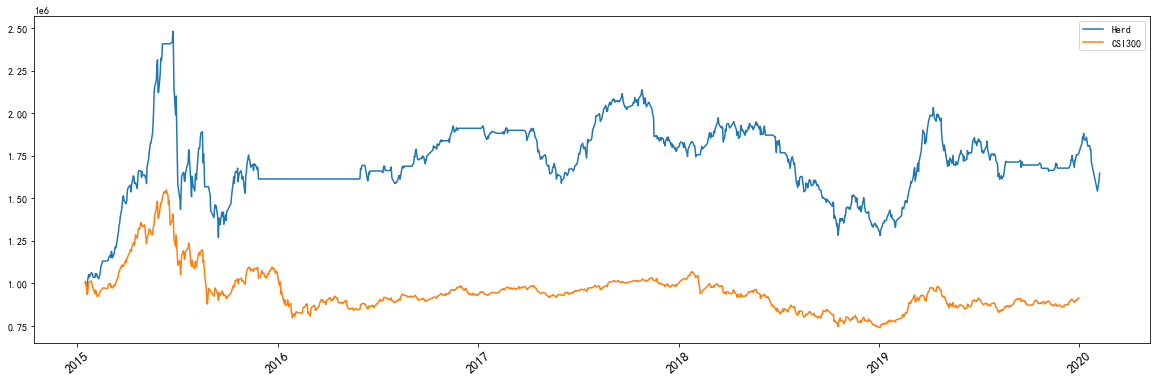

In [2]:
stock_zh_index_daily_df = ak.stock_zh_index_daily(symbol="sh000001")
CSI300 = stock_zh_index_daily_df[(stock_zh_index_daily_df.index >= parameters_grid_dict['beginning_date']) &\
                                 (stock_zh_index_daily_df.index <= parameters_grid_dict['ending_date'])]['close']
CSI300.index = pd.to_datetime(CSI300.index, format='%Y-%m-%d').date
output.index = pd.to_datetime(output.index, format='%Y-%m-%d').date
CSI300 = CSI300/CSI300[0]*1000000
performance = pd.concat([output, CSI300], axis=1)
performance.columns = ['Herd','CSI300']
performance.plot(figsize=(20,6))
plt.xticks(size='small',rotation=40,fontsize=13)
plt.show()

<AxesSubplot:>

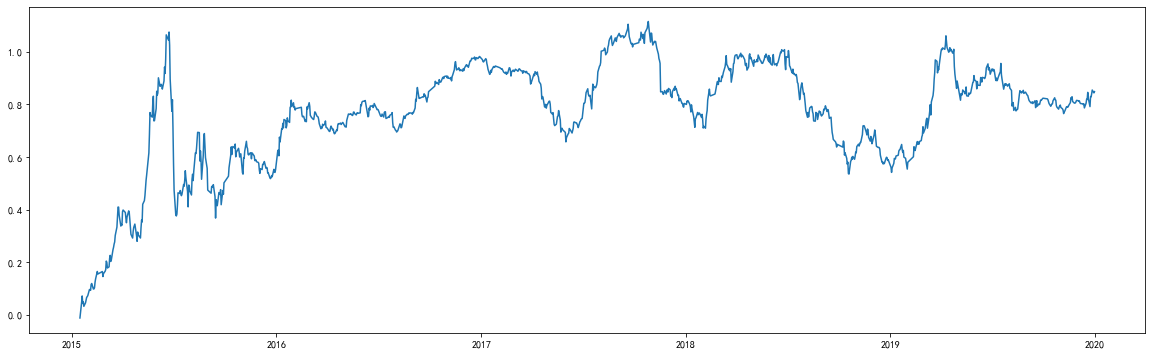

In [3]:
performance_1 = performance.dropna(axis=0, how='any')
alpha = (performance_1['Herd'] - performance_1['CSI300'])/1000000
alpha.plot(figsize=(20,6))

## Trade by Open

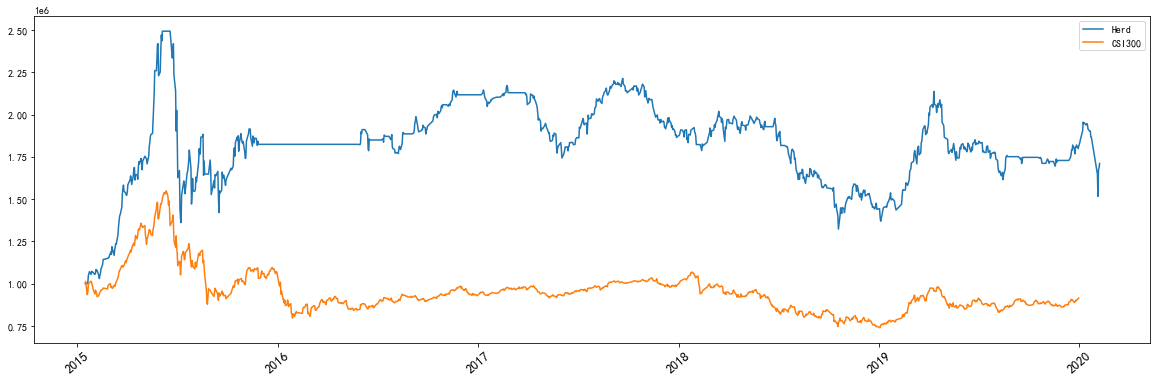

In [5]:
stock_zh_index_daily_df = ak.stock_zh_index_daily(symbol="sh000001")
CSI300 = stock_zh_index_daily_df[(stock_zh_index_daily_df.index >= parameters_grid_dict['beginning_date']) &\
                                 (stock_zh_index_daily_df.index <= parameters_grid_dict['ending_date'])]['close']
CSI300.index = pd.to_datetime(CSI300.index, format='%Y-%m-%d').date
output.index = pd.to_datetime(output.index, format='%Y-%m-%d').date
CSI300 = CSI300/CSI300[0]*1000000
performance = pd.concat([output, CSI300], axis=1)
performance.columns = ['Herd','CSI300']
performance.plot(figsize=(20,6))
plt.xticks(size='small',rotation=40,fontsize=13)
plt.show()

<AxesSubplot:>

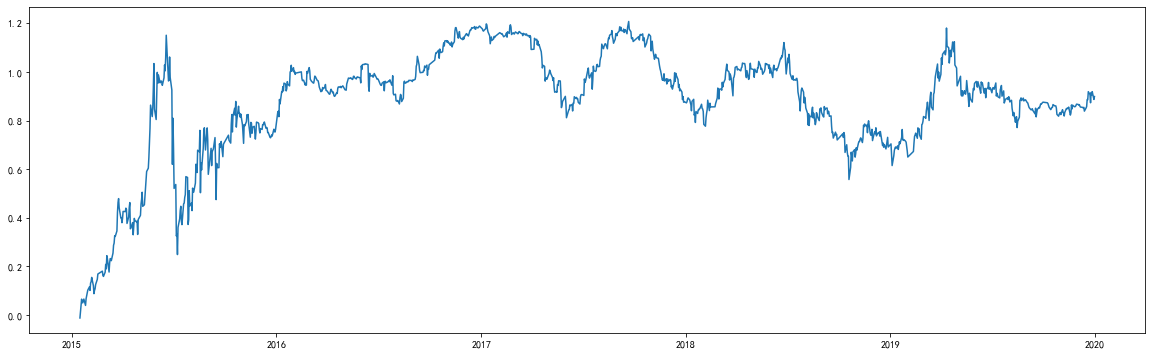

In [6]:
performance_1 = performance.dropna(axis=0, how='any')
alpha = (performance_1['Herd'] - performance_1['CSI300'])/1000000
alpha.plot(figsize=(20,6))